In [9]:
import numpy as np 
import cv2
from PIL import Image
import matplotlib.pyplot as plt 
import os
import torch
import torch.nn as nn
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import ToTensor
import torchvision.transforms as T 
from torchvision.transforms import Compose
from torchvision.transforms import RandomHorizontalFlip, RandomCrop,Normalize
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam
device='cuda:3' if torch.cuda.is_available() else 'cpu'
device


'cpu'

In [8]:
print(torch.cuda.get_device_name(), device = 0) # 'NVIDIA TITAN X (Pascal)'

# 사용 가능 GPU 개수 체크
print(torch.cuda.device_count()) # 3

AssertionError: Torch not compiled with CUDA enabled

데이터 불러오기

Files already downloaded and verified
Files already downloaded and verified


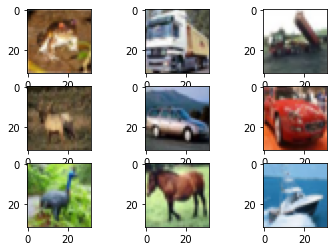

In [ ]:
training_data=CIFAR10(
    root='../data/',
    train=True,
    download=True,
    transform=ToTensor()
)
test_data=CIFAR10(
    root='../data/',
    train=False,
    download=True,
    transform=ToTensor()
)

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(training_data.data[i])
plt.show()

데이터 증강

Files already downloaded and verified
Files already downloaded and verified


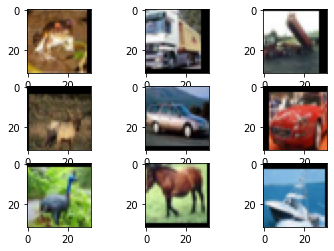

In [ ]:
transforms=Compose([
    T.ToPILImage(),
    RandomCrop((32,32),padding=4),
    RandomHorizontalFlip(p=0.5),
])

training_data=CIFAR10(
    root='../data/',
    train=True,
    download=True,
    transform=transforms
)
test_data=CIFAR10(
    root='../data/',
    train=False,
    download=True,
    transform=transforms
)

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(transforms(training_data.data[i]))
plt.show()


데이터 정규화

Files already downloaded and verified
Files already downloaded and verified


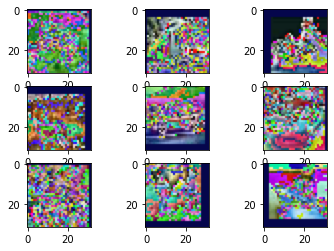

In [ ]:
transforms=Compose([
    T.ToPILImage(),
    RandomCrop((32,32),padding=4),
    RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    
    Normalize(mean=(0.4914,0.4822,0.4465),std=(0.247,0.243,0.261)),
    T.ToPILImage()
])

training_data=CIFAR10(
    root='../data/',
    train=True,
    download=True,
    transform=transforms
)
test_data=CIFAR10(
    root='../data/',
    train=False,
    download=True,
    transform=transforms
)

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(transforms(training_data.data[i]))
plt.show()

데이터셋의 평균과 표준편차

In [ ]:
training_data=CIFAR10(
    root='../data/',
    train=True,
    download=True,
    transform=ToTensor()
)

imgs=[item[0] for item in training_data]
imgs= torch.stack(imgs,dim=0).numpy()

mean_r = imgs[:,0,:,:].mean()
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()
print(mean_r,mean_g,mean_b)

std_r = imgs[:,0,:,:].std()
std_g = imgs[:,1,:,:].std()
std_b = imgs[:,2,:,:].std()
print(std_r,std_g,std_b)

Files already downloaded and verified
0.49139968 0.48215827 0.44653124
0.24703233 0.24348505 0.26158768


BasicBlock

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self,in_channels,out_channels,hidden_dim):
        super(BasicBlock,self).__init__()
        self.conv1=nn.Conv2d(in_channels,hidden_dim,kernel_size=3,padding=1)
        self.conv2=nn.Conv2d(hidden_dim,out_channels,kernel_size=3,padding=1)
        self.relu=nn.ReLU()
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
        
    def forward(self,x):
        x=self.conv1(x)
        x=self.relu(x)
        x=self.conv2(x)
        x=self.relu(x)
        x=self.pool(x)
        
        return x
    

CNN 모델 정의

In [ ]:
class CNN(nn.Module):
    def __init__(self,num_class):
        super(CNN,self).__init__()
        self.block1=BasicBlock(in_channels=3,out_channels=32,hidden_dim=16)
        self.block2=BasicBlock(in_channels=32,out_channels=128,hidden_dim=64)
        self.block3=BasicBlock(in_channels=128,out_channels=256,hidden_dim=128)
        
        self.fc1=nn.Linear(in_features=4096,out_features=2048)
        self.fc2=nn.Linear(in_features=2048,out_features=256)
        self.fc3=nn.Linear(in_features=256,out_features=num_class)
        
        self.relu=nn.ReLU()
        
    def forward(self,x):
        x=self.block1(x)
        x=self.block2(x)
        x=self.block3(x)
        x=torch.flatten(x,start_dim=1)
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        x=self.relu(x)
        x=self.fc3(x)
        
        return x

In [ ]:
transforms=Compose([
    RandomCrop((32,32),padding=4),
    RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    Normalize(mean=(0.4914,0.4822,0.4465),std=(0.247,0.243,0.261)),
])

training_data=CIFAR10(
    root='../data/',
    train=True,
    download=True,
    transform=transforms
)
test_data=CIFAR10(
    root='../data/',
    train=False,
    download=True,
    transform=transforms
)

train_loader=DataLoader(training_data,batch_size=32,shuffle=True)
test_loader=DataLoader(test_data,batch_size=32,shuffle=False)


model=CNN(num_class=10)

model.to(device)

Files already downloaded and verified
Files already downloaded and verified


CNN(
  (block1): BasicBlock(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): BasicBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=256,

In [ ]:
lr=1e-3

optim=Adam(model.parameters(),lr=lr)

for epoch in range(100):
    for data,label in train_loader:
        optim.zero_grad()
        preds=model(data.to(device))
        loss=nn.CrossEntropyLoss()(preds,label.to(device))
        loss.backward()
        
    if epoch==0 or epoch%10==9:
        print(f"epoch : {epoch+1} loss : {loss.item()}")
torch.save(model.state_dict(),"CIFAR.pth")

epoch : 1 loss : 2.3016676902770996


In [ ]:
torch.cuda.is_available()

False

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14289955188533887144
 xla_global_id: -1]